In [2]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## split: train 0.2 / test 0.8

In [2]:
# standard model is MPCFs from Kabbur's PhD thesis
# https://conservancy.umn.edu/bitstream/handle/11299/171241/Kabbur_umn_0130E_15806.pdf?sequence=1&isAllowed=y
no_side_info_model_metrics = pd.read_csv('data/results/2016-04-21_15.54.04_no-si_e50_tt-0.2_zero-samp-3_no-val_metrics.csv')


# model which gets regularized by doc2vec vectors from movie subtitles
# si = side information model, e50 = 50 epochs, tt-0.2 = train 0.2/test 0.8 split,
# zero-samp-3 = 3 * number of train samples taken as zero samples
side_info_model_metrics = pd.read_csv('data/results/2016-04-21_15.17.52_si_e50_tt-0.2_zero-samp-3_no-val_metrics.csv')

In [3]:
side_info_model_metrics.head()

,auc,avg_precision,f1,fcp,nb_movies_not_in_train,nb_test_movies,nb_train_movies,precision_at_20,rankings,recall_at_20,reciprocal_rank,spearman_rank_corr,user_id
0,0.915284,0.176724,0.218182,0.788618,2995,42,10,0.30,"[[1, 3, 4, 9, 14, 16, 19, 28, 32, 43, 45, 48, ...",0.171429,0.500000,0.321747,1
1,0.870127,0.219929,0.214286,0.755759,2979,103,26,0.45,"[[0, 3, 6, 8, 9, 12, 16, 17, 18, 22, 23, 24, 3...",0.140625,1.000000,0.372267,2
2,0.862564,0.101460,0.133333,0.830065,3000,18,5,0.10,"[[6, 8, 21, 25, 34, 49, 75, 91, 109, 110, 119,...",0.200000,0.142857,0.612124,12
3,0.874459,0.273490,0.213592,0.762500,2965,160,40,0.55,"[[0, 1, 2, 3, 4, 5, 6, 9, 11, 13, 15, 16, 17, ...",0.132530,1.000000,0.260608,15
4,0.844112,0.359100,0.183007,0.804016,2964,166,41,0.70,"[[0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 16, 1...",0.105263,1.000000,0.389576,17


In [4]:
print "max number of train ratings:", side_info_model_metrics['nb_train_movies'].max()
print "min number of train ratings:", side_info_model_metrics['nb_train_movies'].min()

max number of train ratings: 418
min number of train ratings: 3


In [3]:
def get_cohorts(df, step=5, func=None, cumulative=False):
    results = []
    max_nb_ratings = df['nb_train_movies'].max()
    start, end = 0, step
    while end < max_nb_ratings:
        mask = (df['nb_train_movies'] >= start) & (df['nb_train_movies'] < end)
        df_cohort = df.loc[mask]
        cohort_result = func(df_cohort) if func else df_cohort
        results.append(cohort_result)
        if not cumulative:
            start += step
        end += step
    return results

def get_user_cohorts(df_train, step=5, cumulative=False):
    df_train = df_train.groupby('user_id')['rating'].count().reset_index()
    df_train = df_train.rename(columns={'rating': 'nb_train_movies'})
    return get_cohorts(df_train, step=step, cumulative=cumulative)

def get_movie_cohorts(df_train, step=5, cumulative=False):
    df_train = df_train.groupby('movie_id')['rating'].count().reset_index()
    df_train = df_train.rename(columns={'rating': 'nb_train_movies'})
    return get_cohorts(df_train, step=step, cumulative=cumulative)

def plot_user_cohort_distribution(df_train, step=5):
    print "Cohort 0: users who have 0-5 training ratings"
    print "Cohort 1: users who have 5-10 training ratings"
    
    user_cohorts = get_user_cohorts(df_train, step=step)
    nb_users_per_cohort = map(lambda df: len(df), user_cohorts)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('number of users')
    ax.set_xlabel('cohort (users)')
    ax.plot(xrange(len(nb_users_per_cohort)),nb_users_per_cohort, 'b')
    
    cumulative_users = np.cumsum(nb_users_per_cohort, dtype=np.float)
    cumulative_users /= cumulative_users[-1]
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('percent of users')
    ax.set_xlabel('have x or less training ratings')
    x_axis = [(i+1) * step for i in xrange(len(cumulative_users))]
    ax.plot(x_axis,cumulative_users, 'b')
    
def plot_movie_cohort_distribution(df_train, step=5):
    print "Cohort 0: movies who have 0-5 training ratings"
    print "Cohort 1: movies who have 5-10 training ratings"
    
    movie_cohorts = get_movie_cohorts(df_train, step=step)
    nb_movies_per_cohort = map(lambda df: len(df), movie_cohorts)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('number of movies')
    ax.set_xlabel('cohort (movie)')
    ax.plot(xrange(len(nb_movies_per_cohort)),nb_movies_per_cohort, 'b')
    
    cumulative_movies = np.cumsum(nb_movies_per_cohort, dtype=np.float)
    cumulative_movies /= cumulative_movies[-1]
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('percent of movies')
    ax.set_xlabel('have x or less training ratings')
    x_axis = [(i+1) * step for i in xrange(len(cumulative_movies))]
    ax.plot(x_axis,cumulative_movies, 'b')

In [4]:
def compare_metric(model1_metrics, model2_metrics, metric_name, step=5, cumulative=False, label1='No Side Information', label2='Side Information'):
    func = lambda df: df[metric_name].mean()
    
    model1_metric_per_cohort = get_cohorts(model1_metrics, step=step, func=func, cumulative=cumulative)
    model2_metric_per_cohort = get_cohorts(model2_metrics, step=step, func=func, cumulative=cumulative)
        
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('avg {}'.format(metric_name))
    if cumulative:
        ax.set_xlabel('have x or less training ratings')
        x_axis = [(i+1) * step for i in xrange(len(model1_metric_per_cohort))]
    else:
        ax.set_xlabel('cohort')
        x_axis = [i for i in xrange(len(model1_metric_per_cohort))]
    assert len(model1_metric_per_cohort) == len(model2_metric_per_cohort)

    ax.plot(x_axis, model1_metric_per_cohort, 'r', label=label1)
    ax.plot(x_axis, model2_metric_per_cohort, 'g', label=label2)
    ax.legend(loc='upper right')
    
    print "avg {} for {} model:\t".format(metric_name, label1), model1_metrics[metric_name].mean()
    print "avg {} for {} model:\t".format(metric_name, label2), model2_metrics[metric_name].mean()

Cohort 0: users who have 0-5 training ratings
Cohort 1: users who have 5-10 training ratings


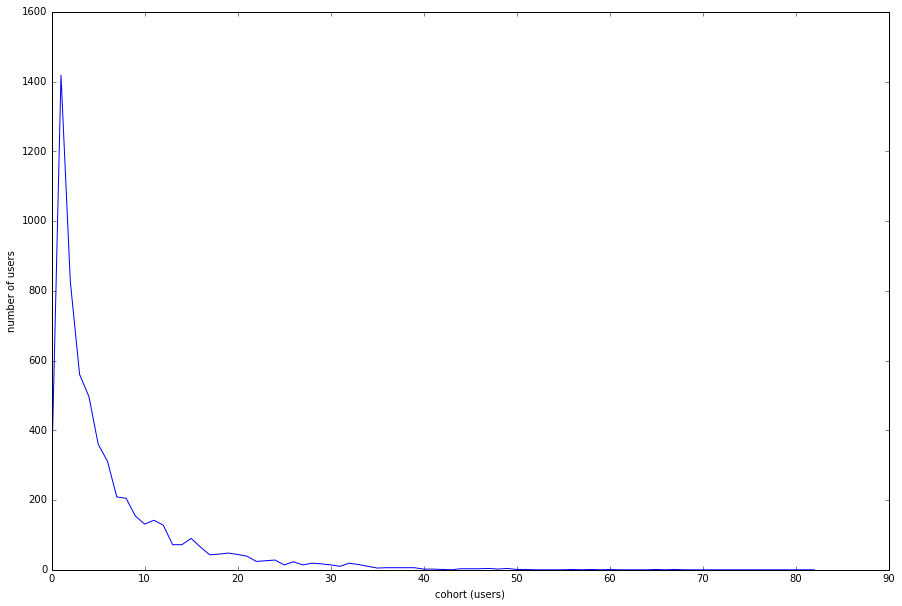

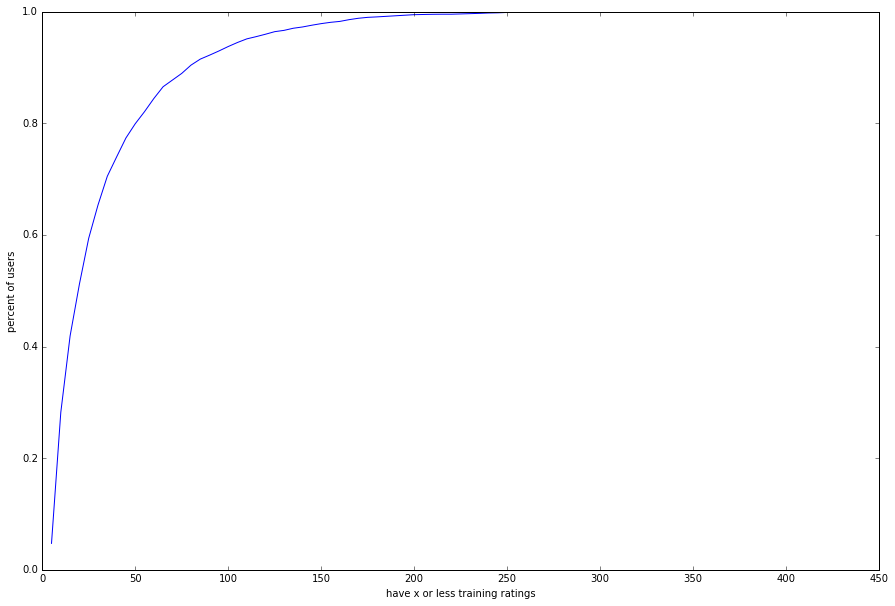

In [7]:
train = pd.read_csv('data/splits/0.2-train.csv')
plot_user_cohort_distribution(train)

Cohort 0: movies who have 0-5 training ratings
Cohort 1: movies who have 5-10 training ratings


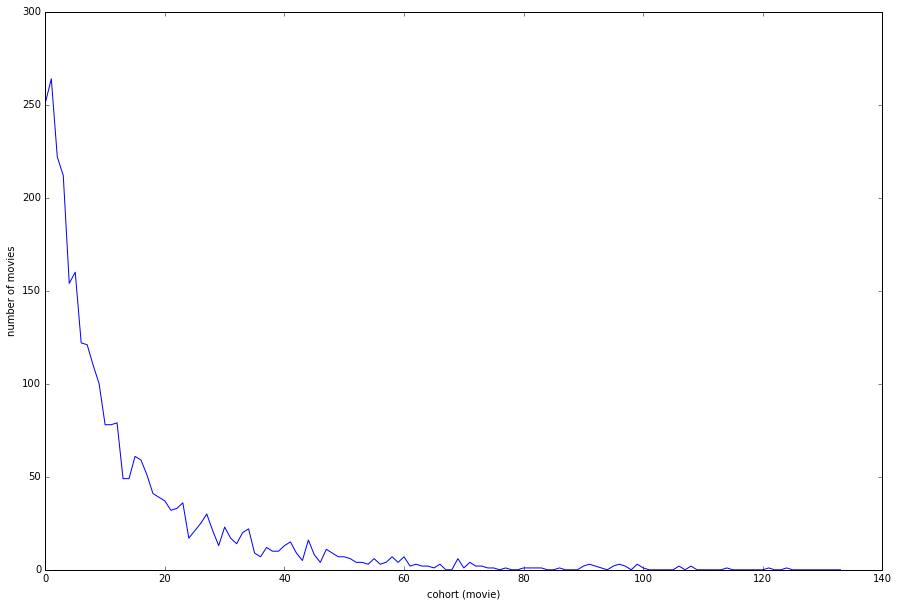

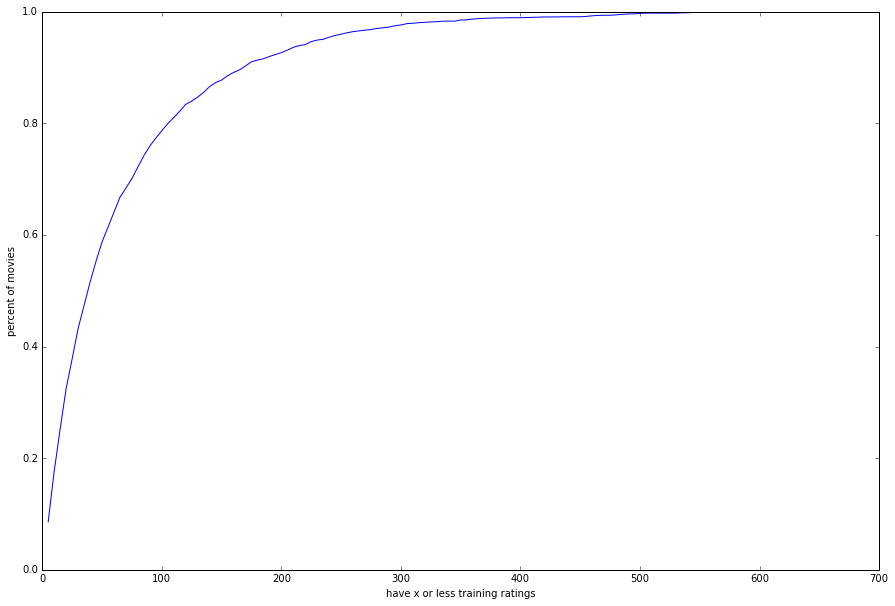

In [8]:
plot_movie_cohort_distribution(train)

avg auc for No Side Information model:	0.832635376426
avg auc for Side Information model:	0.849357499917


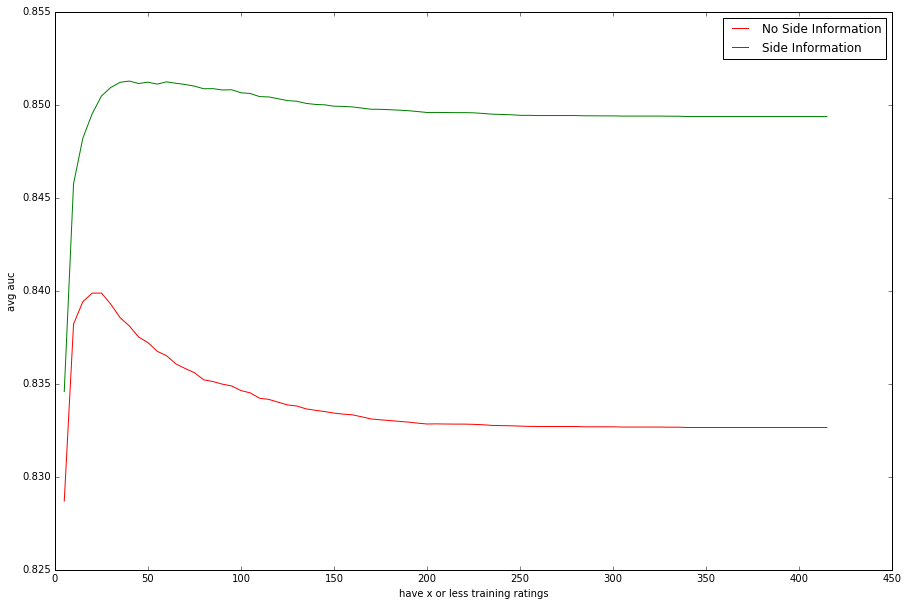

In [9]:
compare_metric(no_side_info_model_metrics, side_info_model_metrics, 'auc', step=5, cumulative=True)

avg avg_precision for No Side Information model:	0.18999476135
avg avg_precision for Side Information model:	0.213058958103


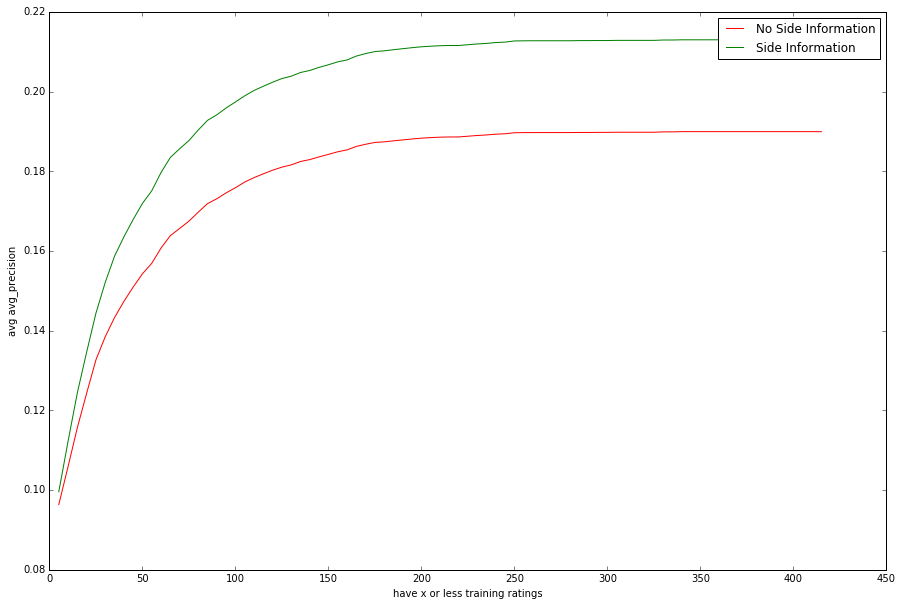

In [10]:
compare_metric(no_side_info_model_metrics, side_info_model_metrics, 'avg_precision', cumulative=True)

avg f1 for No Side Information model:	0.142560533849
avg f1 for Side Information model:	0.152893422722


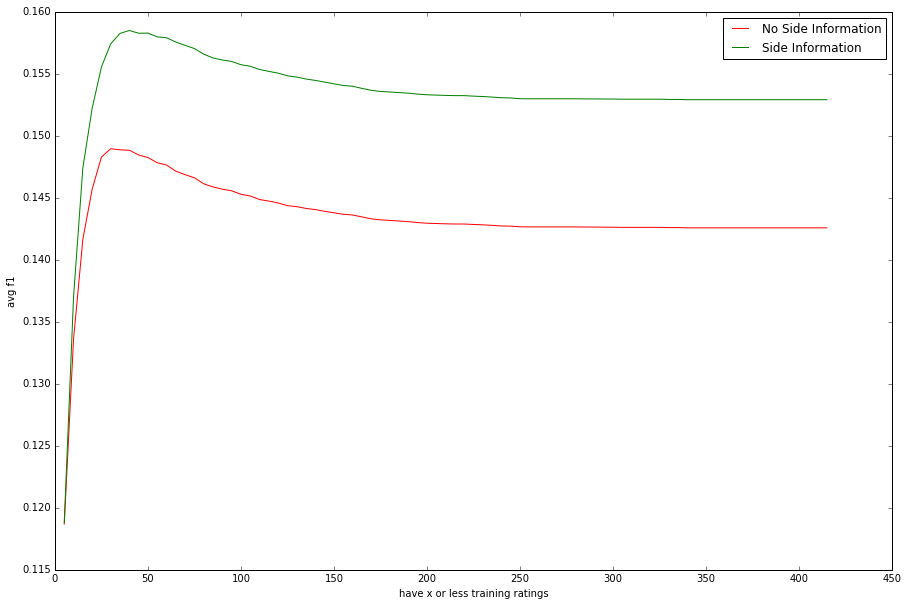

In [11]:
compare_metric(no_side_info_model_metrics, side_info_model_metrics, 'f1', cumulative=True)

avg precision_at_20 for No Side Information model:	0.313435430464
avg precision_at_20 for Side Information model:	0.340471854305


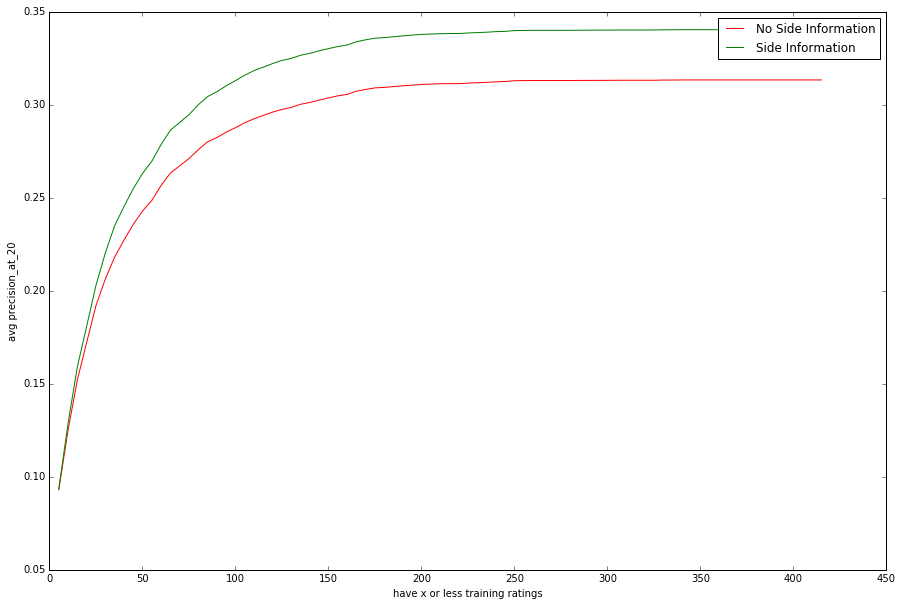

In [12]:
compare_metric(no_side_info_model_metrics, side_info_model_metrics, 'precision_at_20', cumulative=True)

avg recall_at_20 for No Side Information model:	0.115165773912
avg recall_at_20 for Side Information model:	0.122272253017


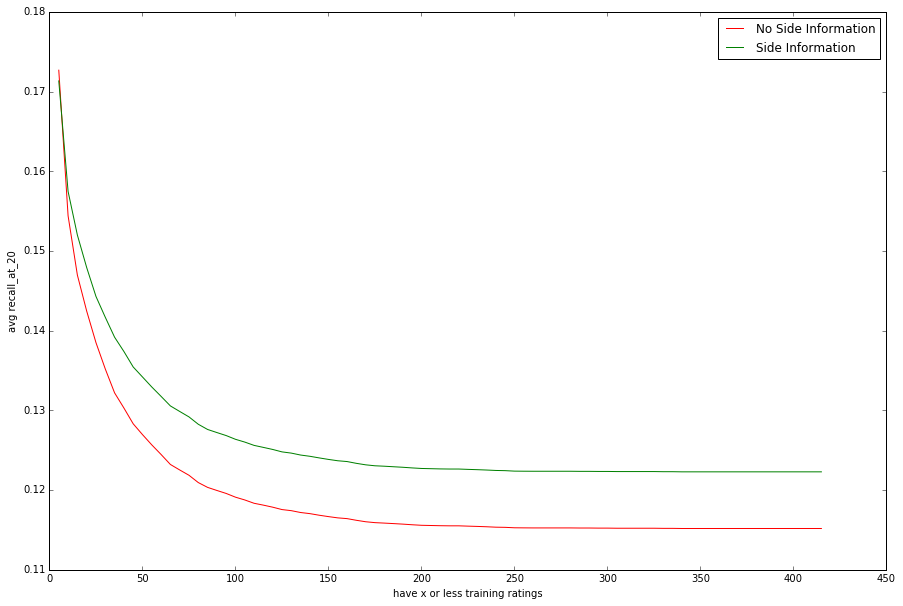

In [13]:
compare_metric(no_side_info_model_metrics, side_info_model_metrics, 'recall_at_20', cumulative=True)

avg fcp for No Side Information model:	0.746979830142
avg fcp for Side Information model:	0.752044267895


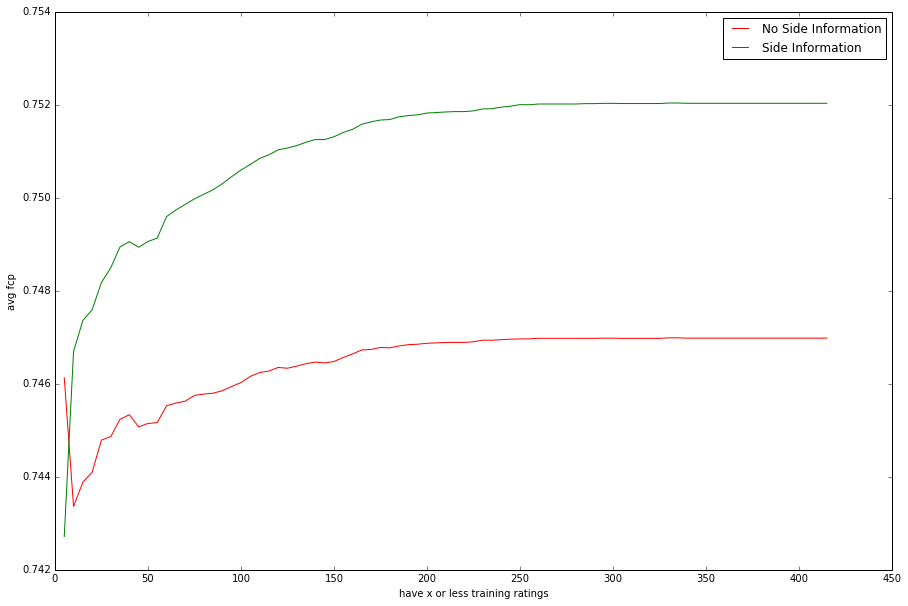

In [14]:
# Fraction of Concordant Pairs
compare_metric(no_side_info_model_metrics, side_info_model_metrics, 'fcp', cumulative=True)

avg spearman_rank_corr for No Side Information model:	0.283687844133
avg spearman_rank_corr for Side Information model:	0.298850355128


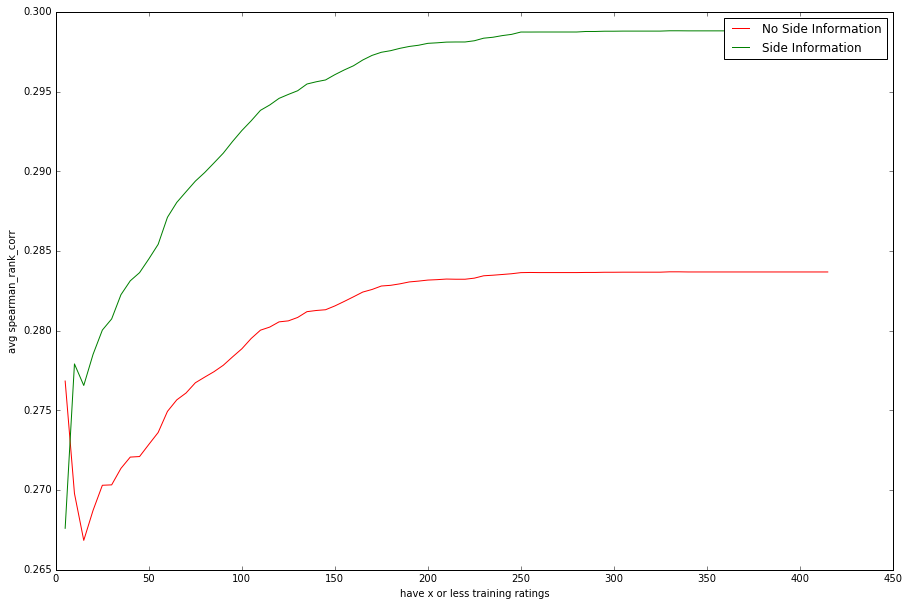

In [15]:
compare_metric(no_side_info_model_metrics, side_info_model_metrics, 'spearman_rank_corr', cumulative=True)

avg reciprocal_rank for No Side Information model:	0.585965946032
avg reciprocal_rank for Side Information model:	0.642350838322


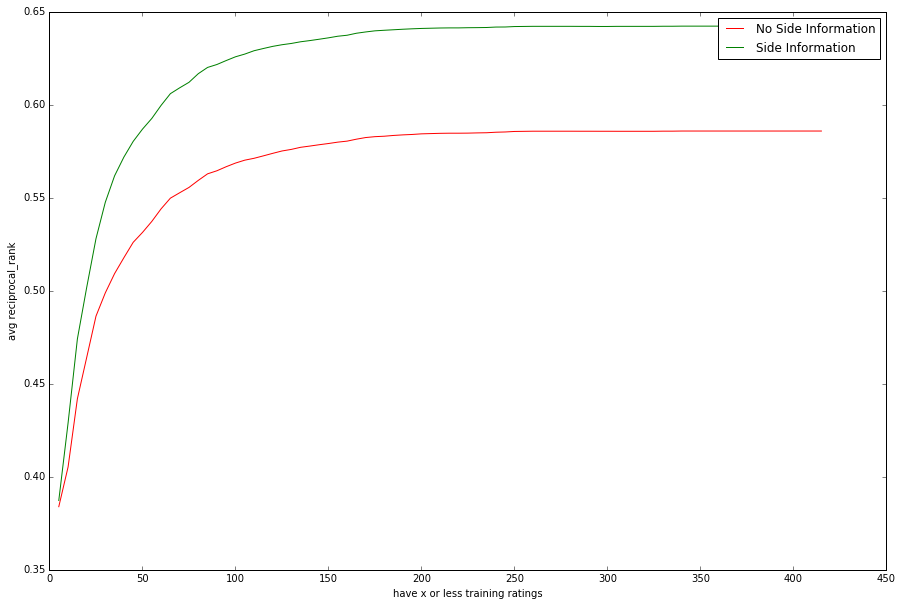

In [16]:
compare_metric(no_side_info_model_metrics, side_info_model_metrics, 'reciprocal_rank', cumulative=True)

In [17]:
side_info_model_1_metrics = pd.read_csv('data/results/2016-04-21_22.48.22_si_e20_tt-0.2_zero-samp-3_lrdqi_1e-3_no-val_metrics.csv')

side_info_model_2_metrics = pd.read_csv('data/results/2016-04-21_15.03.05_no-si_e20_tt-0.2_zero-samp-3_no-val_metrics.csv')

avg auc for si model:	0.83655935595
avg auc for no si model:	0.833138629593


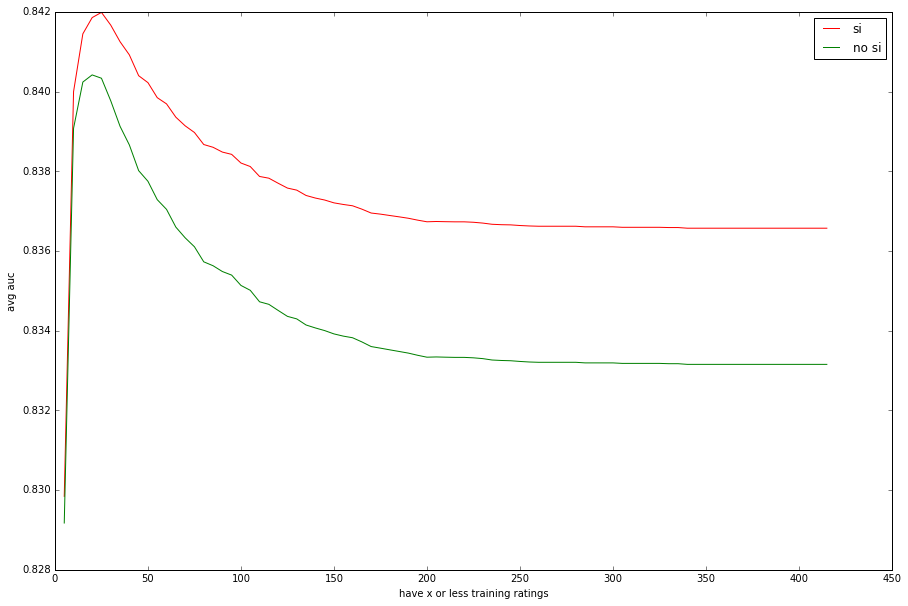

In [18]:
compare_metric(side_info_model_1_metrics, side_info_model_2_metrics, 'auc', cumulative=True, label1='si', label2='no si')

avg auc for No SI, normal ratings model:	0.826884160804
avg auc for No SI, binarized ratings model:	0.83534741527
avg avg_precision for No SI, normal ratings model:	0.215420367553
avg avg_precision for No SI, binarized ratings model:	0.211548922502


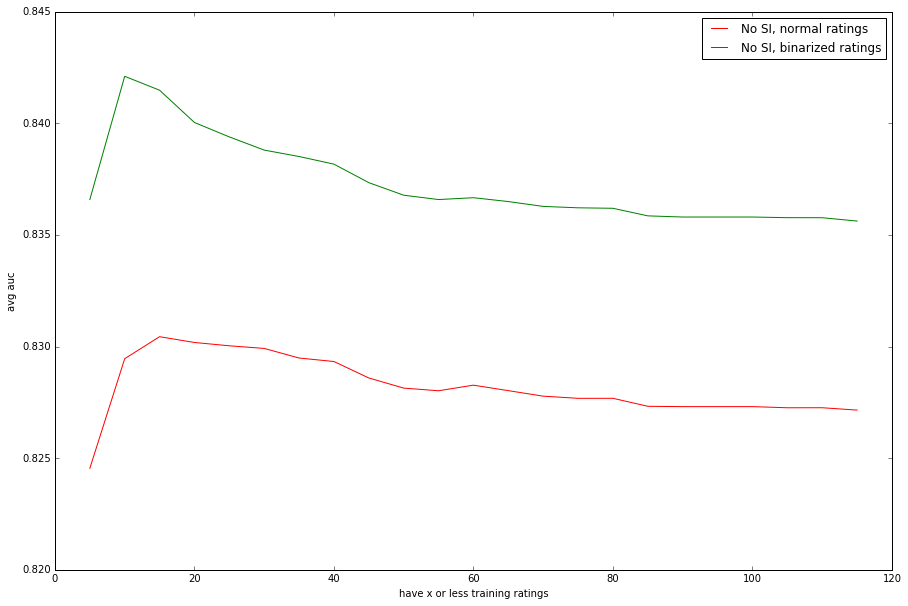

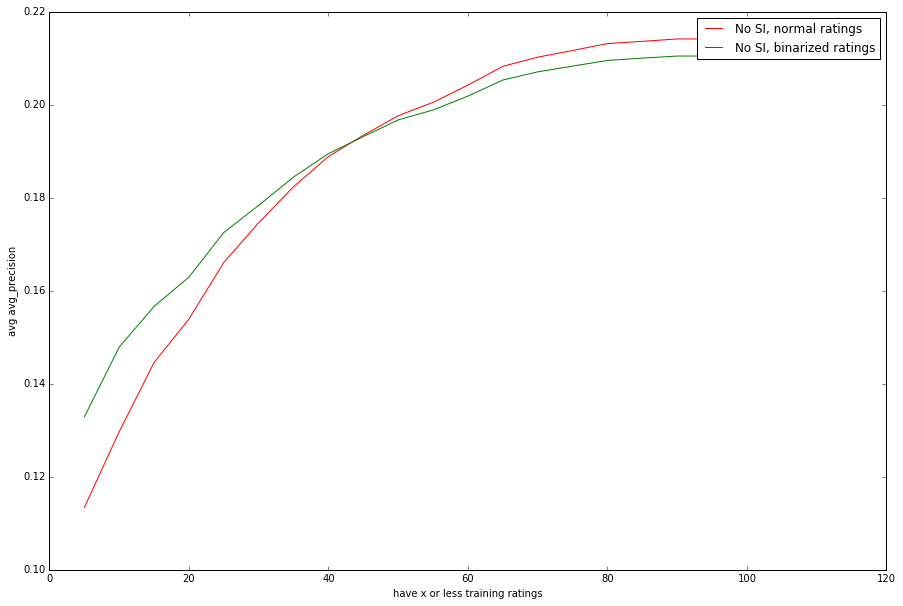

In [20]:
# ml-100k
no_si_metrics = pd.read_csv('data/results/2016-04-25_20.57.51_no-si_ml-100k_e20_tt-0.2_zero-samp-3_sparse-item_no-val_metrics.csv')
no_si_binarized_metrics = pd.read_csv('data/results/2016-04-26_14.00.16_no-si_ml-100k_e20_tt-0.2_zero-samp-3_sparse-item_binarize_no-val_metrics.csv')
compare_metric(no_si_metrics, no_si_binarized_metrics, 'auc', cumulative=True, label1='No SI, normal ratings', label2='No SI, binarized ratings')
compare_metric(no_si_metrics, no_si_binarized_metrics, 'avg_precision', cumulative=True, label1='No SI, normal ratings', label2='No SI, binarized ratings')